# Development of a classifier for month 1

Here we look at 2 months of activity and then try to determine whether the user will leave in the subsequent month.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score, accuracy_score


def prepare_time_series(df, month_array, type_operation, groupby_feature = 'user_id'):
    
    # If we want to append each month as a seperate feature 
    if type_operation == 'append':
        
        # Find the months of interest
        df_new = df[df.index.get_level_values(1).isin(month_array)].unstack().fillna(0)
        
        # Name new columns
        new_cols = [str(item[0]) + '_' + str(int(item[1])) for item in df_new.columns]
        
        # Drop level and rename
        df_new.columns = df_new.columns.droplevel(0)
        df_new.columns = new_cols
    
    # If we want to sum the values of each feature for every month
    elif type_operation == 'sum':
        df_new = df[df.index.get_level_values(1).isin(month_array)]
        df_new = df_new.reset_index().groupby(groupby_feature).sum()
    
    return df_new

In [2]:
# Inputs
source_csv = '/home/work/GitHub/data/teacher_churn/edit_teacher_timeseries_month.csv'
source_user = '/home/work/GitHub/data/user_info.csv'
modelFileName = '/home/work/GitHub/data/teacher_churn/model_1.pkl'

# Reading dataframes
df = pd.read_csv(source_csv)
df_user = pd.read_csv(source_user)

# Exracting info
df_user = df_user.set_index('id')
df_user['registration_date'] = pd.to_datetime(df_user['registration_date'])
df_user['start_month'] = df_user['registration_date'].apply(lambda x:str(x.month))
df_user['start_year'] = df_user['registration_date'].apply(lambda x:x.year)
df_user = df_user[['start_month','start_year']]

# Displayign info
df_user.head()

,start_month,start_year
id,,
d94c077ad88fc2b7a1204ba16c30f93961d86ededecbb47bef25063cb4835c12,11,2015
1ef02c359b5b66b584da8d46d1f790f509eeb55b80a908b6d3c3ad4c758b216b,10,2015
eed0d25033826f9786fc61daef41f9f6c0046248254e3c348a08bcb83b11ffb1,12,2015
5937dd6ec7778da3dc7cc63303439bcc6a622da83fdf4afdadfd6586c31af1e7,11,2015
68a983c9bfca031c77b2159cf651a624a893a02cc79bdd0624effddc2d3ff699,4,2015


In [3]:
last_month = 1;

# Find users that have churned
plot_churn = df.reset_index().groupby('index')['event_leg'].max()

# Remove users that have churned before last month
plot_churn = plot_churn[plot_churn.values >= last_month]
df_lm = df.set_index(['index','event_leg']).loc[plot_churn.index.values]

# Remove rows all greater than last_month
df_lm = df_lm[df_lm.index.get_level_values(1)<=last_month]
plot_churn =plot_churn.loc[np.unique(df_lm.index.get_level_values(0).values)]

# Label those that churned at last month
label = [1 if item == last_month else 0 for item in plot_churn.values]
df_lm = df_lm.loc[plot_churn.index.values]

# CLean off any nan
df_lm = df_lm.fillna(0)

# Add rows for months that may not exist for a user and set as zero
df_lm = df_lm.unstack(level='event_leg').stack(level='event_leg',dropna=False).fillna(0)

# Display the dataframe
df_lm.head(10)

add_assig  \
index                                              event_leg              
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0              0.0   
                                                   1.0              0.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996... 0.0              0.0   
                                                   1.0              0.0   
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de8... 0.0              0.0   
                                                   1.0              1.0   
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c59... 0.0              0.0   
                                                   1.0              0.0   
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6be... 0.0              0.0   
                                                   1.0              0.0   

                                                              add_custom_assig  \
index                                              event_leg                     
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                     0.0   
                                                   1.0                     0.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996... 0.0                     0.0   
                                                   1.0                     0.0   
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de8... 0.0                     3.0   
                                                   1.0                     0.0   
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c59... 0.0                     8.0   
                                                   1.0                     0.0   
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6be... 0.0                     0.0   
                                                   1.0                     0.0   

                                                              add_user  \
index                                              event_leg             
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0             0.0   
                                                   1.0             0.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996... 0.0             0.0   
                                                   1.0             0.0   
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de8... 0.0            10.0   
                                                   1.0             1.0   
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c59... 0.0            23.0   
                                                   1.0             3.0   
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6be... 0.0             0.0   
                                                   1.0             0.0   

                                                              create_group  \
index                                              event_leg                 
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                 0.0   
                                                   1.0                 0.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996... 0.0                 0.0   
                                                   1.0                 0.0   
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de8... 0.0                 1.0   
                                                   1.0                 0.0   
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c59... 0.0                 2.0   
                                                   1.0                 0.0   
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6be... 0.0                 0.0   
                                                   1.0                 0.0   

                                                              play_video  \
index                                              event_leg               
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0               8.0   
                                                   1.0               1.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d399

In [4]:
# Prepare timeseries
df_lm_new = prepare_time_series(df_lm.groupby(['index','event_leg']).sum(),[0,1,2,3,4,5,6,7,8,9,10,11,12],'append')

# Adding features
df_lm_new = df_lm_new.join(pd.get_dummies(df_user))

df_lm_new.head()

,add_assig_0,add_assig_1,add_custom_assig_0,add_custom_assig_1,add_user_0,add_user_1,create_group_0,create_group_1,play_video_0,play_video_1,...,start_month_11,start_month_12,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9
index,,,,,,,,,,,,,,,,,,,,,
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996d14b7e53a3094ed80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de85b0764b714db2ba90,0.0,1.0,3.0,0.0,10.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c592c6f1fe2c5b7b0028,0.0,0.0,8.0,0.0,23.0,3.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6beba1546c8acc819591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,0,1,0,0,0,0,0


(array([ 1146.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   192.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

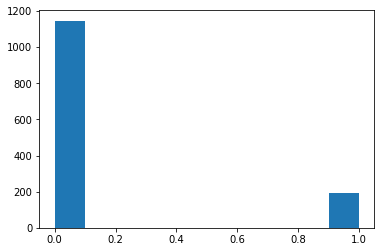

In [5]:
# Check class distribution
plt.hist(label)


[115  20]
[115  20]
[115  19]
[115  19]
[115  19]
[115  19]
[114  19]
[114  19]
[114  19]
[114  19]


,Accuracy,Precision,Recall
0,0.851852,0.500000,0.100000
1,0.859259,0.600000,0.150000
2,0.843284,0.250000,0.052632
3,0.873134,0.750000,0.157895
4,0.873134,0.666667,0.210526
5,0.843284,0.333333,0.105263
6,0.872180,1.000000,0.105263
7,0.849624,0.400000,0.105263
8,0.879699,0.714286,0.263158
9,0.887218,1.000000,0.210526


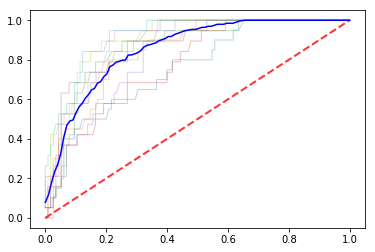

In [24]:
from scipy import interp

# Fill in any zeros
df_lm_new = df_lm_new.fillna(0)

# Assign data to auxillary variables
X = df_lm_new
y = np.array(label)

# Remove some of the columns
X = X.drop('start_year',axis=1)

# Storing the keys
store_keys = X.keys()

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X)
X = X_trf

# Now let's use KFolds optimisation
NUM_FOLDS = 10
kf = StratifiedKFold(n_splits = NUM_FOLDS)

score = [];
tprs = []
prec_recall=[]

mean_fpr = np.linspace(0, 1, 100)

precision = [None]*NUM_FOLDS
recall = [None]*NUM_FOLDS

it = 0;
for train_index, test_index in kf.split(X, y):
    
    # Splitting into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Printing distribution
    print(np.bincount(y_test))
    
    # Training and evaluating classifier
    clf = RF(n_estimators=500, random_state=42)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)
    
    # Saving values in dataframe
    score.append([accuracy_score(y_test, y_pred),precision_score(y_test, y_pred),
                    recall_score(y_test,y_pred)])
    
    # Saving values for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    # Plotting ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3)
    
    # Finding precision-recall
    precision[it], recall[it], _ = precision_recall_curve(y_test, y_score[:,1], pos_label=1)
    
    it +=1
    
# Plotting luck line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

# Plotting mean and std
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.plot(mean_fpr, mean_tpr, color='b')

df_score = pd.DataFrame(score, columns=['Accuracy', 'Precision','Recall'])
df_score.loc['mean'] = df_score.mean()

df_score

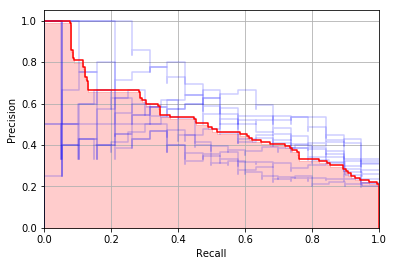

In [25]:
for item in list(zip(recall,precision)):
    #plt.plot(item[0],item[1],alpha=0.2)
    plt.step(item[0], item[1], color='b', alpha=0.2,
         where='post')
    #plt.fill_between(item[0], item[1], step='post', alpha=0.2,
     #            color='b')
        
mean_recall_prec = []

for it in range(NUM_FOLDS):
    
   mean_recall_prec.append(np.interp(np.linspace(0, 1, 100),precision[it],recall[it]))


plt.step(np.mean(mean_recall_prec, axis=0),np.linspace(0,1,100),color='r')
plt.fill_between(np.mean(mean_recall_prec, axis=0),np.linspace(0,1,100), step='post', alpha=0.2,color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid()

plt.savefig(str(last_month)+'_tch_churn.png', format='png', dpi=300)

In [26]:
## Here we will train the model on the entire dataset and save

# Training the model on the whole dataset
model = RF(n_estimators=500)
model.fit(X,y)

# Saving the model
pickle.dump(model, open(modelFileName, 'wb'))

# Model can be loaded as
# loaded_model = pickle.load(open(filename, 'rb'))

             precision    recall  f1-score   support

          0       0.89      0.96      0.92       115
          1       0.55      0.32      0.40        19

avg / total       0.84      0.87      0.85       134



(array([ 115.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   19.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

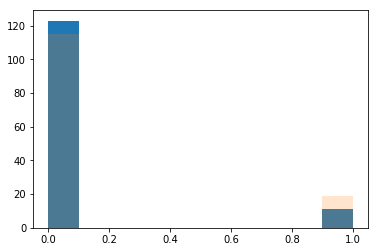

In [11]:
## Plot one feature against another to determine who to contact from churned individuals

# Input

test_size = 0.1

# Split again into 2 categories
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=42)

# Train and test
clf = RF(n_estimators=100, random_state=42);
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
print(classification_report(y_test,y_pred))

# Plotting
plt.hist(y_pred)
plt.hist(y_test,alpha=0.2)

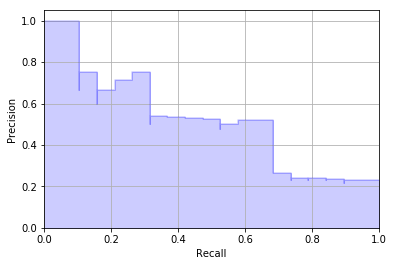

In [12]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])
plt.grid()


In [13]:
# Split again
df_train, df_test, y_train, y_test = train_test_split(df_lm_new,y,test_size=test_size, random_state=42)

# Add another array of probabilites
df_test['Prob_leaving'] = y_score[:,1]

# Print the array
df_test.head()

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,add_assig_0,add_assig_1,add_custom_assig_0,add_custom_assig_1,add_user_0,add_user_1,create_group_0,create_group_1,play_video_0,play_video_1,...,start_month_12,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,Prob_leaving
index,,,,,,,,,,,,,,,,,,,,,
8ac43a38d266670ad3eb4250b788a5842f1914ec44cd26192d9b6819f34d4874,2.0,0.0,8.0,10.0,42.0,1.0,0.0,0.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0.160000
a546643153238dab5accb72c6b708f8111766ebfdf31b2b9270ac7cc37f2454a,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0.270000
a66508b8b1247ab2bf5e8cf34513b81fec4479b5732af50022d1656b04c10f23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0.000000
f7006bb15b9c2aca24ff235564abba59883f29d809a10ab4c3dbcc2aa6508274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0.596845
2f34b3f3b589c297d0e6c13aa7f55d4009eee5a05194480e2d32ce8b9db8cbad,0.0,0.0,2.0,2.0,32.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0.150000


In [14]:
df_lm_new.keys()

Index(['add_assig_0', 'add_assig_1', 'add_custom_assig_0',
       'add_custom_assig_1', 'add_user_0', 'add_user_1', 'create_group_0',
       'create_group_1', 'play_video_0', 'play_video_1', 'q_lvl_0_0',
       'q_lvl_0_1', 'q_lvl_0_cor_0', 'q_lvl_0_cor_1', 'q_lvl_1_0', 'q_lvl_1_1',
       'q_lvl_1_cor_0', 'q_lvl_1_cor_1', 'q_lvl_2_0', 'q_lvl_2_1',
       'q_lvl_2_cor_0', 'q_lvl_2_cor_1', 'q_lvl_3_0', 'q_lvl_3_1',
       'q_lvl_3_cor_0', 'q_lvl_3_cor_1', 'q_lvl_4_0', 'q_lvl_4_1',
       'q_lvl_4_cor_0', 'q_lvl_4_cor_1', 'q_lvl_5_0', 'q_lvl_5_1',
       'q_lvl_5_cor_0', 'q_lvl_5_cor_1', 'q_lvl_6_0', 'q_lvl_6_1',
       'q_lvl_6_cor_0', 'q_lvl_6_cor_1', 'view_assig_prog_0',
       'view_assig_prog_1', 'view_concept_0', 'view_concept_1', 'view_hint_0',
       'view_hint_1', 'start_year', 'start_month_1', 'start_month_10',
       'start_month_11', 'start_month_12', 'start_month_2', 'start_month_3',
       'start_month_4', 'start_month_5', 'start_month_6', 'start_month_7',
       'start_mon

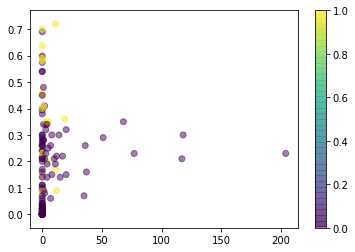

In [15]:
# Do a bunch of scatter plot

x_plot = df_test['view_assig_prog_0']
y_plot = df_test['Prob_leaving']

plt.scatter(x_plot,y_plot, c=y_test,alpha=0.5)
plt.colorbar()

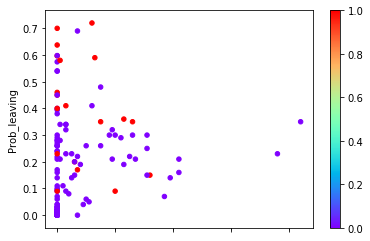

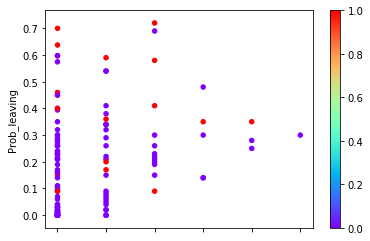

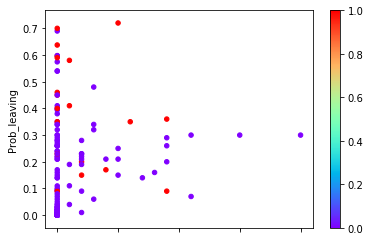

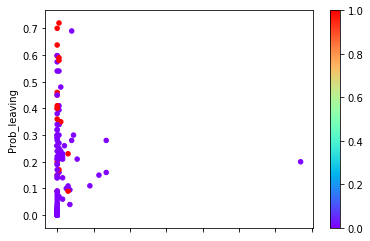

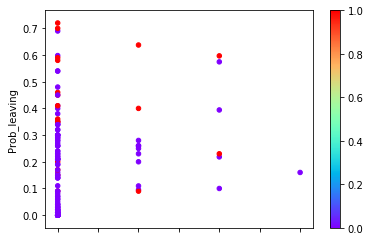

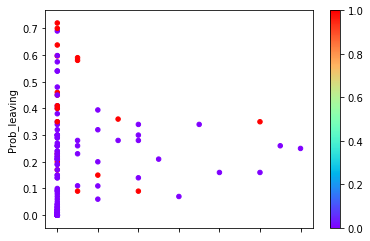

In [16]:
y_label = 'Prob_leaving'
x_array = ['add_user_0','create_group_0','add_custom_assig_0','add_user_1','create_group_1','add_custom_assig_1']


for item in x_array:
    
    df_test.plot(kind='scatter',x=item,y=y_label,c=y_test,cmap='rainbow')
    plt.xlabel(item)
    plt.show()
    

/home/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


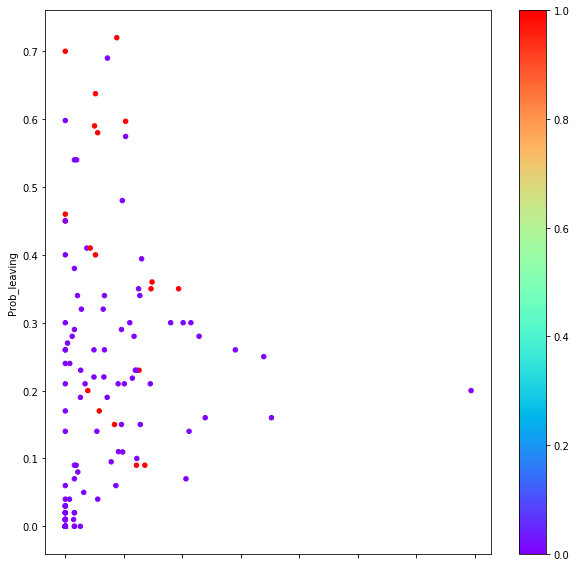

In [17]:
df_test['Tot'] = (df_test[x_array]/df_test[x_array].mean()).sum(axis=1)

df_test.plot(kind='scatter',x='Tot',y='Prob_leaving',c=y_test,cmap='rainbow',figsize=(10,10))

In [30]:
df_lm_new.iloc[0:10].to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>add_assig_0</th>\n      <th>add_assig_1</th>\n      <th>add_custom_assig_0</th>\n      <th>add_custom_assig_1</th>\n      <th>add_user_0</th>\n      <th>add_user_1</th>\n      <th>create_group_0</th>\n      <th>create_group_1</th>\n      <th>play_video_0</th>\n      <th>play_video_1</th>\n      <th>q_lvl_0_0</th>\n      <th>q_lvl_0_1</th>\n      <th>q_lvl_0_cor_0</th>\n      <th>q_lvl_0_cor_1</th>\n      <th>q_lvl_1_0</th>\n      <th>q_lvl_1_1</th>\n      <th>q_lvl_1_cor_0</th>\n      <th>q_lvl_1_cor_1</th>\n      <th>q_lvl_2_0</th>\n      <th>q_lvl_2_1</th>\n      <th>q_lvl_2_cor_0</th>\n      <th>q_lvl_2_cor_1</th>\n      <th>q_lvl_3_0</th>\n      <th>q_lvl_3_1</th>\n      <th>q_lvl_3_cor_0</th>\n      <th>q_lvl_3_cor_1</th>\n      <th>q_lvl_4_0</th>\n      <th>q_lvl_4_1</th>\n      <th>q_lvl_4_cor_0</th>\n      <th>q_lvl_4_cor_1</th>\n      <th>q_lvl_5_0</th>\n      <th>